<a href="https://colab.research.google.com/github/zpsy-hub/Machine-Learning-and-Predictive-Analytics/blob/main/Dropped_Nov_and_Dec_ML_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Load and Prepare Data**
This section loads the cleaned transaction data and performs initial preparation for time series analysis, including converting dates, checking for missing values, and aggregating data by date.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load the cleaned transactions data
transactions = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Machine Learning and Predictive Analytics/cleaned data/cleaned_transactions.csv')

# Display the first few rows of the data
print("Transactions data shape:", transactions.shape)
transactions.head()

Transactions data shape: (9990, 7)


,Transaction_ID,Company_ID,Product_ID,Quantity,Transaction_Date,Product_Price,Total_Cost
0,1,88,6,6,2024-03-26,179200.0,1075200.0
1,2,29,19,16,2024-07-09,95200.0,1523200.0
2,3,28,18,6,2024-04-13,134400.0,806400.0
3,4,85,12,12,2023-09-06,84000.0,1008000.0
4,5,47,3,8,2021-07-06,100800.0,806400.0


# **2. Data Cleaning and Preparation**
Ensure transaction dates are in datetime format, check for missing values, and prepare data for time series analysis.

In [6]:
# Convert Transaction_Date to datetime format
transactions['Transaction_Date'] = pd.to_datetime(transactions['Transaction_Date'])

# Check for missing values
print("\nMissing values in each column:")
print(transactions.isnull().sum())

# Sort data by Transaction_Date
transactions = transactions.sort_values('Transaction_Date')

# Create a daily time series of total sales
daily_sales = transactions.groupby(transactions['Transaction_Date'].dt.date)['Total_Cost'].sum().reset_index()
daily_sales.columns = ['Date', 'Total_Sales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales = daily_sales.set_index('Date')

# Create monthly time series
monthly_sales = daily_sales.resample('M').sum()

# Now you can drop November and December 2024
monthly_sales = monthly_sales[~((monthly_sales.index.year == 2024) & (monthly_sales.index.month.isin([11, 12])))]

# Display the modified data
print("Monthly sales data shape after dropping Nov and Dec 2024:", monthly_sales.shape)
monthly_sales.head()


# Create weekly time series
weekly_sales = daily_sales.resample('W').sum()

# Show the prepared data
print("\nDaily sales data shape:", daily_sales.shape)
print("Monthly sales data shape:", monthly_sales.shape)
print("Weekly sales data shape:", weekly_sales.shape)

daily_sales.head()


Missing values in each column:
Transaction_ID      0
Company_ID          0
Product_ID          0
Quantity            0
Transaction_Date    0
Product_Price       0
Total_Cost          0
dtype: int64
Monthly sales data shape after dropping Nov and Dec 2024: (58, 1)

Daily sales data shape: (1493, 1)
Monthly sales data shape: (58, 1)
Weekly sales data shape: (258, 1)


,Total_Sales
Date,
2020-01-11,1960000.0
2020-01-12,537600.0
2020-02-11,9637600.0
2020-02-12,1724800.0
2020-03-11,1500800.0


# **3. Visualize Time Series Data**
Create visualizations of the sales data at different time intervals (daily, weekly, monthly) to understand patterns and trends.

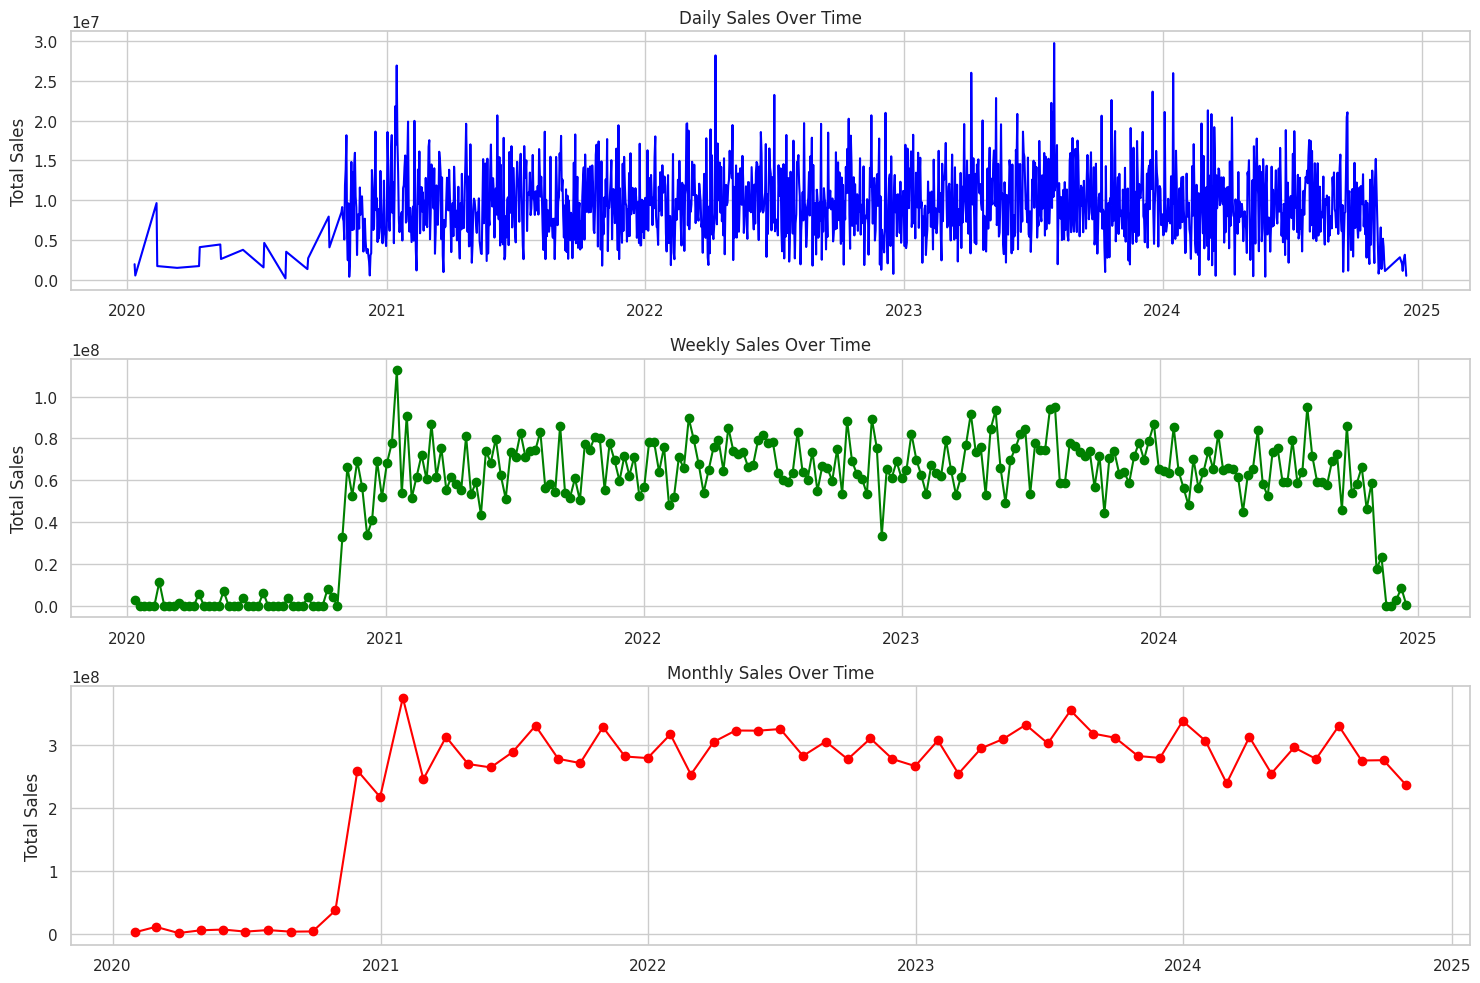

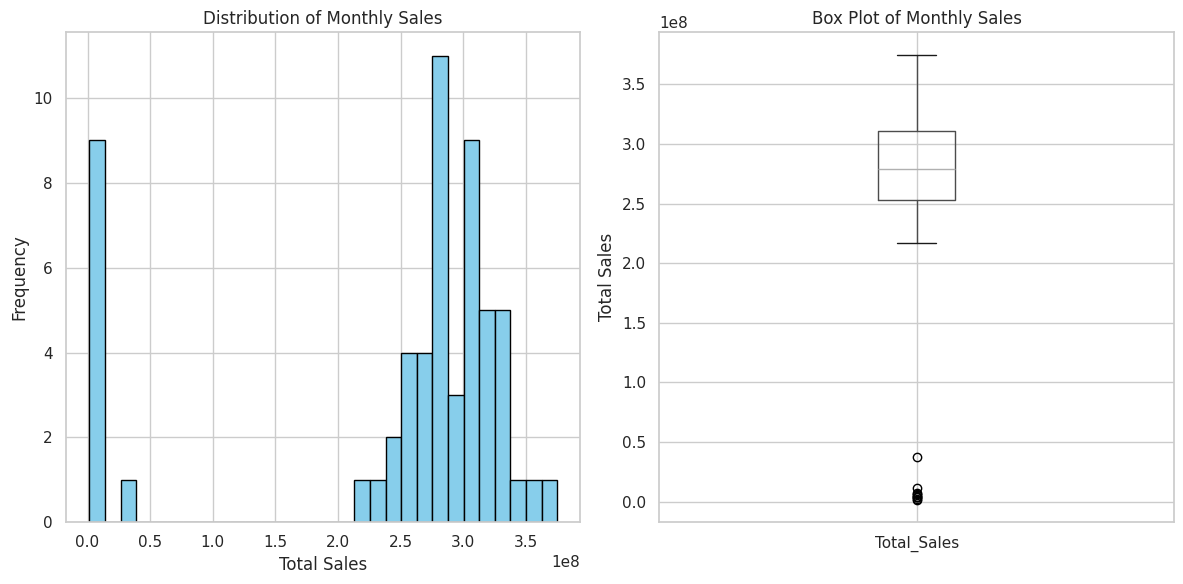

In [7]:
plt.figure(figsize=(15, 10))

# Plot 1: Daily Sales Time Series
plt.subplot(3, 1, 1)
plt.plot(daily_sales.index, daily_sales['Total_Sales'], marker='', linestyle='-', color='blue')
plt.title('Daily Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

# Plot 2: Weekly Sales Time Series
plt.subplot(3, 1, 2)
plt.plot(weekly_sales.index, weekly_sales['Total_Sales'], marker='o', linestyle='-', color='green')
plt.title('Weekly Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

# Plot 3: Monthly Sales Time Series
plt.subplot(3, 1, 3)
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], marker='o', linestyle='-', color='red')
plt.title('Monthly Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display distribution of Total Sales
plt.figure(figsize=(12, 6))

# Plot 1: Histogram of Monthly Sales
plt.subplot(1, 2, 1)
plt.hist(monthly_sales['Total_Sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')

# Plot 2: Box Plot of Monthly Sales
plt.subplot(1, 2, 2)
monthly_sales.boxplot(column=['Total_Sales'])
plt.title('Box Plot of Monthly Sales')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

# **4. Check for Stationarity**
Perform statistical tests to check if the time series is stationary, which is important for ARIMA modeling.

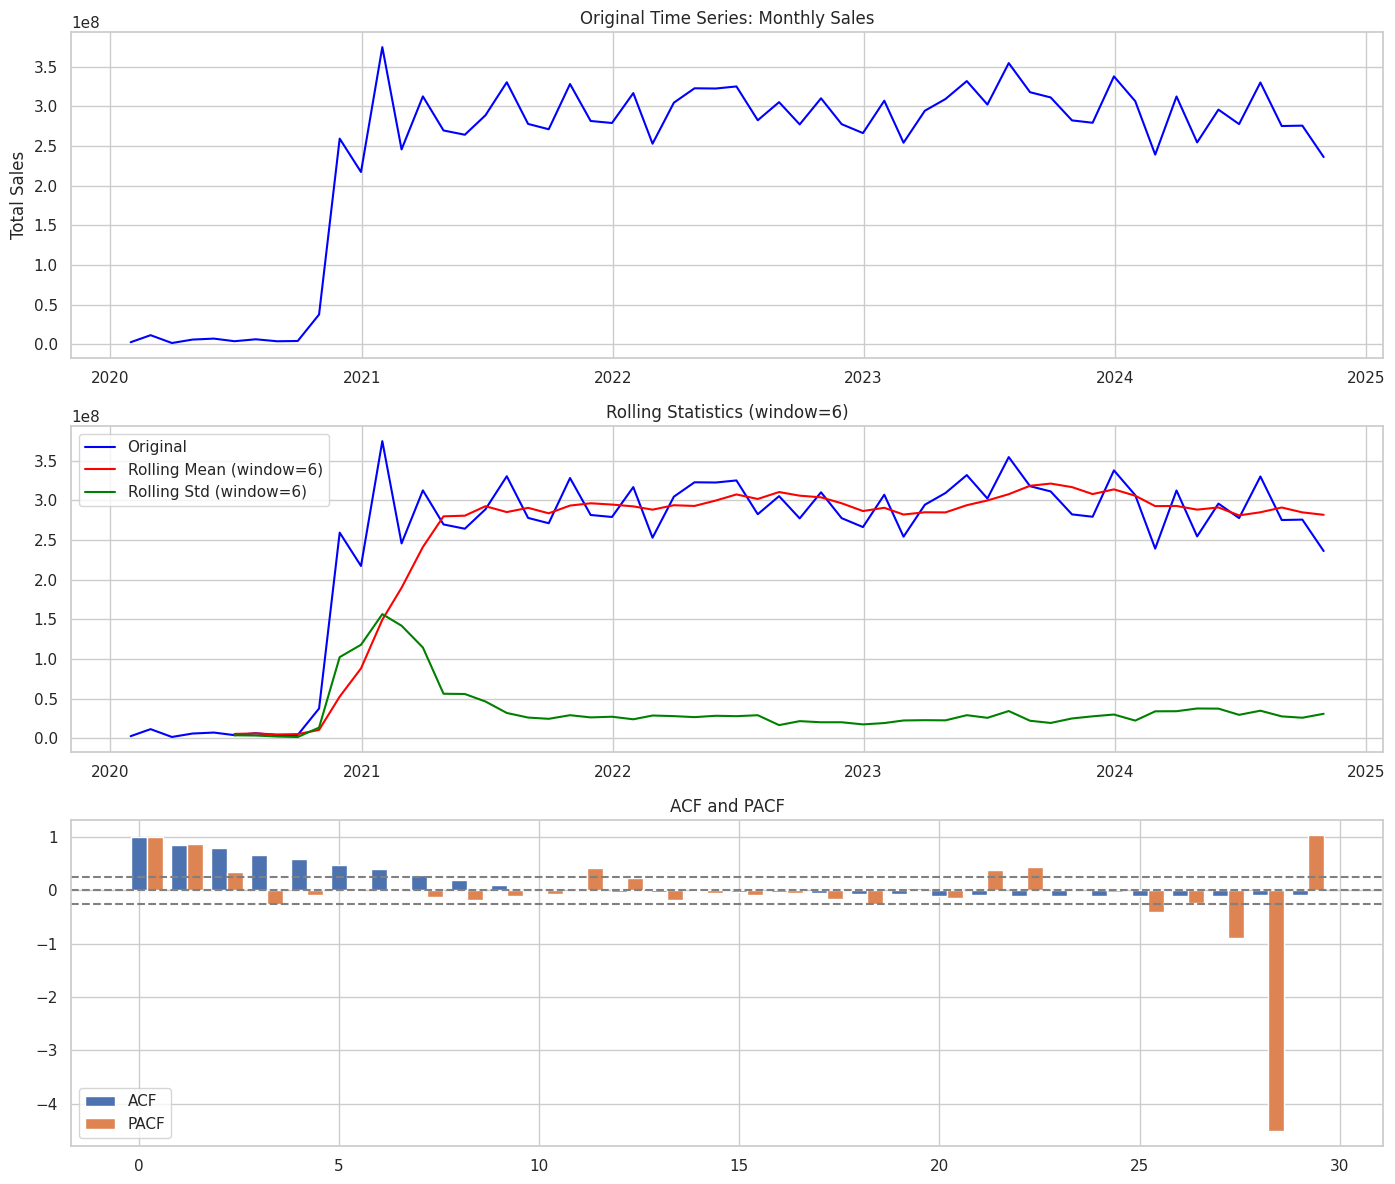

ADF Test:
ADF Statistic: -2.5446033979309064
p-value: 0.10499546205409432
Critical Values:
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997

KPSS Test:
KPSS Statistic: 0.6651188535682121
p-value: 0.01671646785743526
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Test Interpretation: The time series is non-stationary (fail to reject H0)
KPSS Test Interpretation: The time series is non-stationary (reject H0)


In [8]:
def check_stationarity(timeseries, window=12, title=''):
    """
    Check stationarity of a time series using rolling statistics and ADF test
    """
    # Create a figure and subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # Plot the time series
    axes[0].plot(timeseries, color='blue')
    axes[0].set_title(f'Original Time Series: {title}')
    axes[0].set_ylabel('Total Sales')
    axes[0].grid(True)

    # Calculate rolling mean and standard deviation
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # Plot rolling statistics
    axes[1].plot(timeseries, color='blue', label='Original')
    axes[1].plot(rolling_mean, color='red', label=f'Rolling Mean (window={window})')
    axes[1].plot(rolling_std, color='green', label=f'Rolling Std (window={window})')
    axes[1].set_title(f'Rolling Statistics (window={window})')
    axes[1].legend(loc='best')
    axes[1].grid(True)

    # Perform ADF and KPSS tests
    result_adf = adfuller(timeseries.dropna())
    result_kpss = kpss(timeseries.dropna())

    # Plot ACF and PACF
    # Calculate maximum allowable nlags
    max_nlags = len(timeseries.dropna()) // 2
    nlags = min(40, max_nlags)  # Use minimum of 40 and max_nlags

    acf = sm.tsa.stattools.acf(timeseries.dropna(), nlags=nlags)
    pacf = sm.tsa.stattools.pacf(timeseries.dropna(), nlags=nlags)

    axes[2].bar(range(len(acf)), acf, width=0.4, label='ACF')
    axes[2].bar(np.arange(len(pacf)) + 0.4, pacf, width=0.4, label='PACF')
    axes[2].axhline(y=0, linestyle='--', color='gray')
    axes[2].axhline(y=1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    axes[2].axhline(y=-1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    axes[2].set_title('ACF and PACF')
    axes[2].legend(loc='best')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Print test results
    print('ADF Test:')
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print(f'\t{key}: {value}')

    print('\nKPSS Test:')
    print(f'KPSS Statistic: {result_kpss[0]}')
    print(f'p-value: {result_kpss[1]}')
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print(f'\t{key}: {value}')

    # Interpretation
    if result_adf[1] <= 0.05:
        print("\nADF Test Interpretation: The time series is stationary (reject H0)")
    else:
        print("\nADF Test Interpretation: The time series is non-stationary (fail to reject H0)")

    if result_kpss[1] <= 0.05:
        print("KPSS Test Interpretation: The time series is non-stationary (reject H0)")
    else:
        print("KPSS Test Interpretation: The time series is stationary (fail to reject H0)")

# Check stationarity of monthly sales
check_stationarity(monthly_sales['Total_Sales'], window=6, title='Monthly Sales')

# **5. Time Series Decomposition**
Decompose the time series into trend, seasonal, and residual components to better understand its patterns.

Step 5: Time Series Decomposition


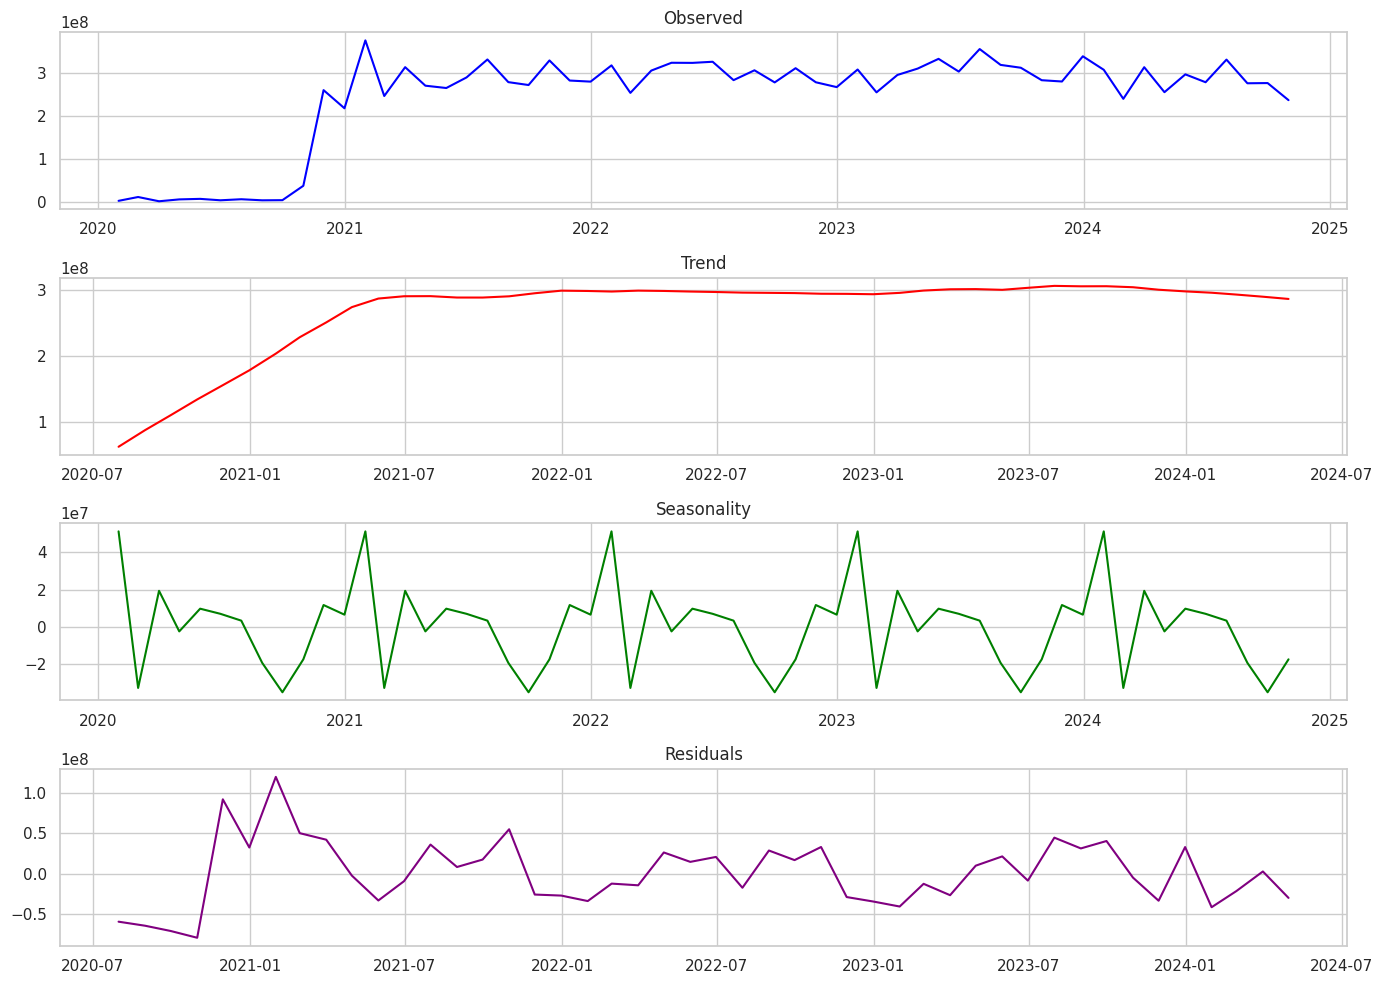

In [9]:
# Step 5: Time Series Decomposition
print("Step 5: Time Series Decomposition")

# Decompose the monthly time series
decomposition = seasonal_decompose(monthly_sales['Total_Sales'], model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.title('Trend')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='purple')
plt.title('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()


1. **Observed (Blue Line)** – This is the actual sales data over time. Sales went up in 2021, stayed stable for a while, and then dropped in 2025.  

2. **Trend (Red Line)** – The overall direction of sales. It shows a steady increase until 2021, then levels off, and finally starts to decline in 2025.  

3. **Seasonality (Green Line)** – Sales follow a repeating pattern, meaning there are regular ups and downs every year, likely due to seasonal trends like holidays or peak shopping times.  

4. **Residuals (Purple Line)** – These are the random ups and downs that don't fit into the trend or seasonal pattern. There was more unexpected variation early on, but it became more stable later.  

Sales **grew, stabilized, and are now dropping**. There is a **clear seasonal pattern**, meaning sales rise and fall at predictable times. However, some unexpected changes also happen occasionally.

# **6. Differencing to Achieve Stationarity**
Apply differencing to make the time series stationary if needed.

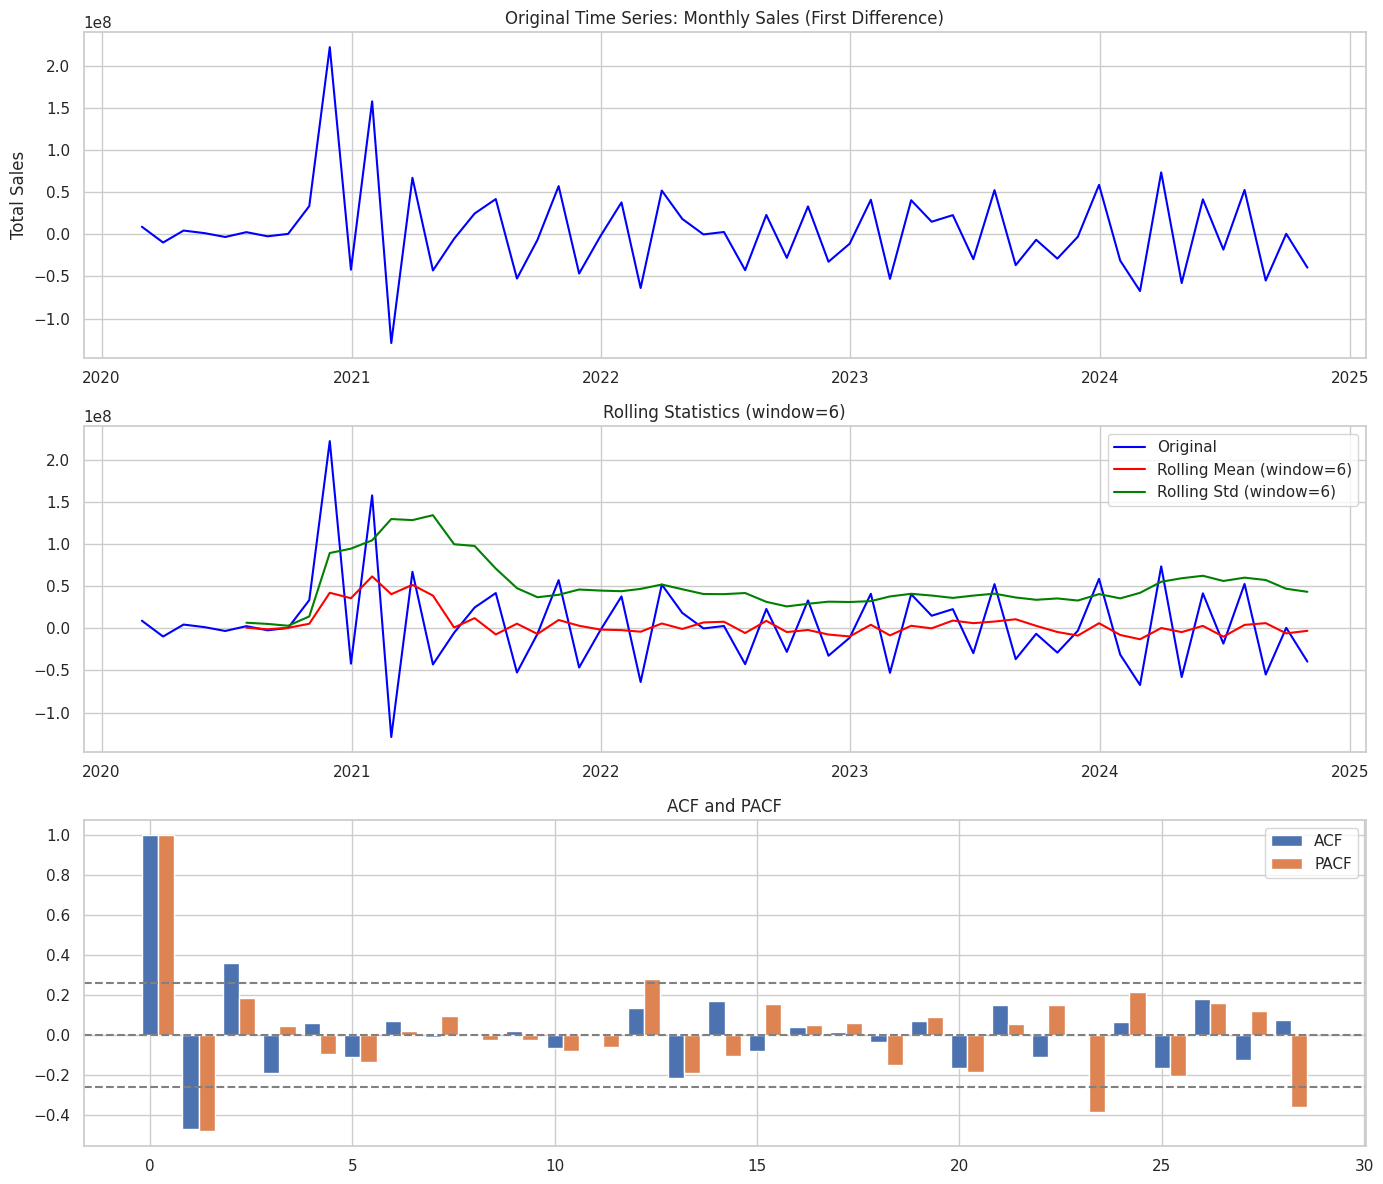

ADF Test:
ADF Statistic: -5.138506163328249
p-value: 1.1723531201482972e-05
Critical Values:
	1%: -3.5552728880540942
	5%: -2.9157312396694217
	10%: -2.5956695041322315

KPSS Test:
KPSS Statistic: 0.2553142038969892
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Test Interpretation: The time series is stationary (reject H0)
KPSS Test Interpretation: The time series is stationary (fail to reject H0)


In [10]:
# First-order differencing
monthly_sales_diff1 = monthly_sales['Total_Sales'].diff().dropna()

# Check stationarity of first-order differenced data
check_stationarity(monthly_sales_diff1, window=6, title='Monthly Sales (First Difference)')

# **7. Auto ARIMA Model Selection**
Use auto_arima to automatically find the best ARIMA model parameters.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2197.036, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2194.521, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2183.360, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2188.599, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2192.862, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2181.994, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2183.338, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2185.338, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2182.277, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2182.802, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2187.444, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2184.353, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=2181.029, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=2182.297, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1

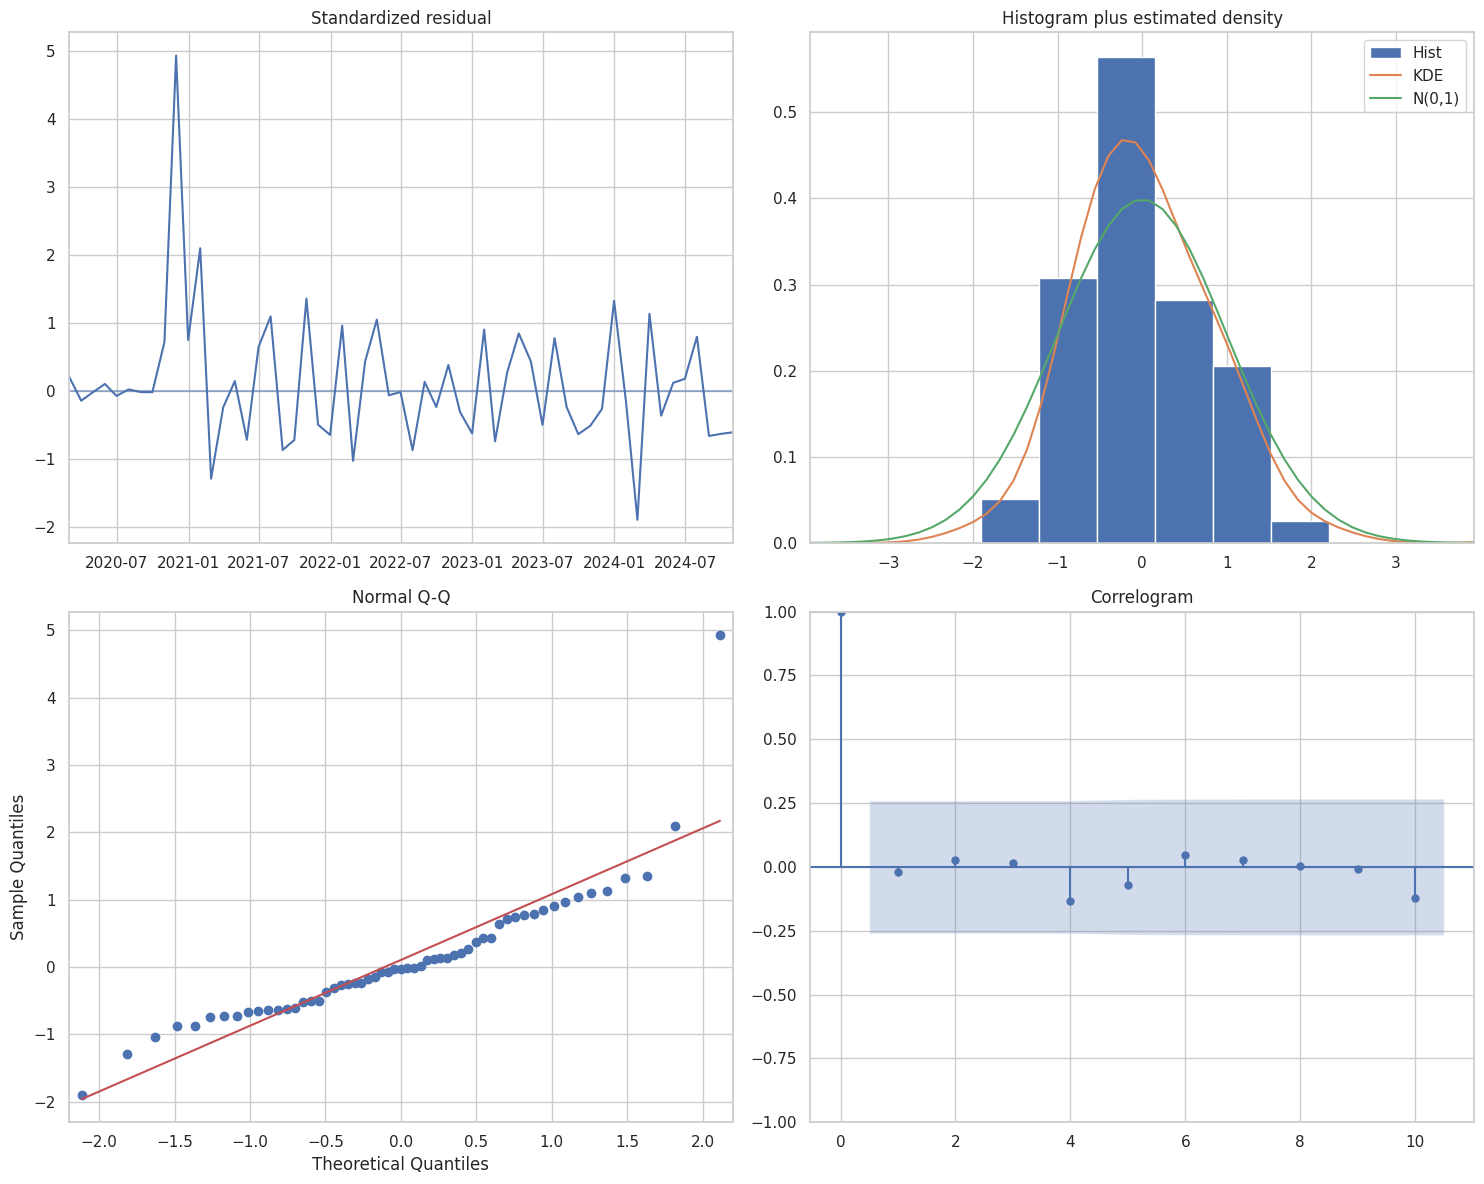

In [11]:
# Apply auto_arima to find the best parameters
auto_model = auto_arima(monthly_sales['Total_Sales'],
                        start_p=0, start_q=0,
                        test='adf',
                        max_p=5, max_q=5,
                        m=12,  # monthly seasonality
                        d=None,  # let the model determine 'd'
                        seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

# Print the summary of the best model
print("\nBest model summary:")
print(auto_model.summary())

# Plot diagnostics
auto_model.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

# **8. ARIMA Model Implementation**
Implement the ARIMA model using the best parameters identified by auto_arima.

Best ARIMA order: (2, 1, 0)
                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   58
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1050.240
Date:                Mon, 10 Mar 2025   AIC                           2106.480
Time:                        17:11:31   BIC                           2112.502
Sample:                    01-31-2020   HQIC                          2108.809
                         - 10-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3762      0.139     -2.713      0.007      -0.648      -0.104
ar.L2          0.1929      0.099      1.948      0.051      -0.001       0.387
sigma2      2.257e+15   

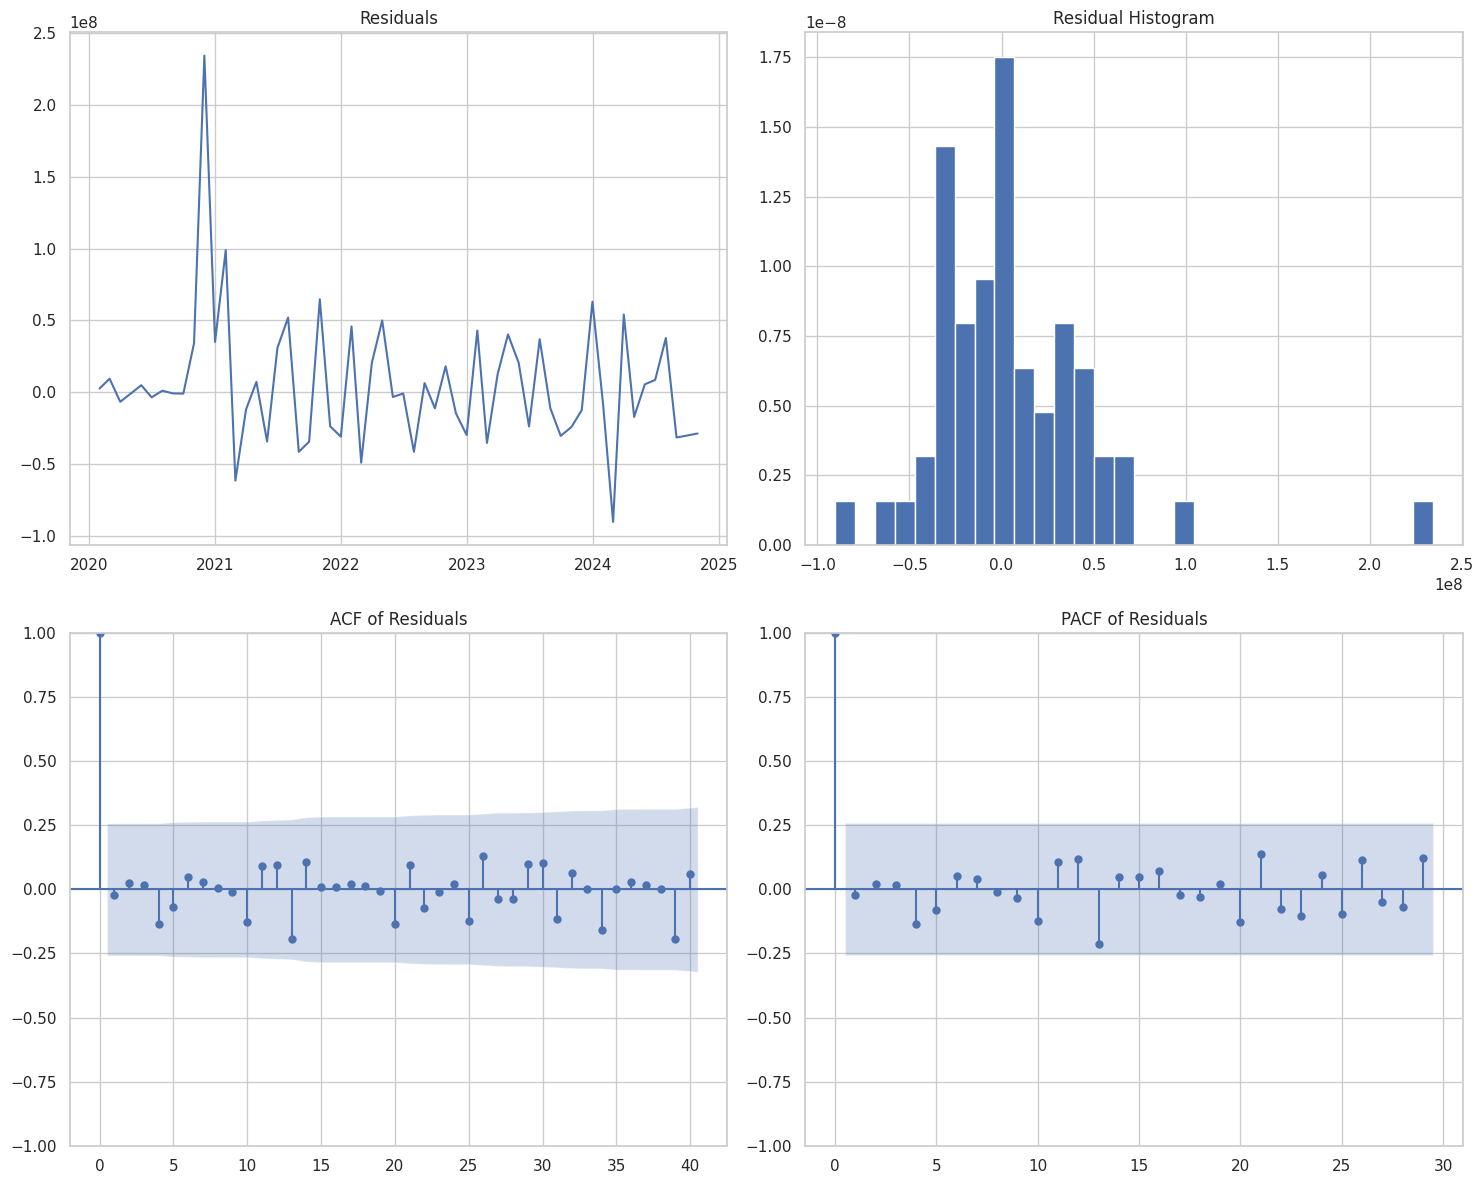

In [12]:
# Extract best parameters from auto_arima (assumed to be already run)
best_order = auto_model.order  # No seasonal order since ARIMA is used
print(f"Best ARIMA order: {best_order}")

# Train the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(monthly_sales['Total_Sales'],
                                       order=best_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)

arima_results = arima_model.fit()

# Print model summary
print(arima_results.summary())

# Plot residual diagnostics
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 12))

# Residuals Plot
plt.subplot(2, 2, 1)
plt.plot(arima_results.resid)
plt.title('Residuals')
plt.grid(True)

# Residual Histogram
plt.subplot(2, 2, 2)
plt.hist(arima_results.resid, bins=30, density=True)
plt.title('Residual Histogram')

# ACF of Residuals
plt.subplot(2, 2, 3)
plot_acf(arima_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

# PACF of Residuals
plt.subplot(2, 2, 4)
max_nlags = len(arima_results.resid) // 2
nlags = min(40, max_nlags)
plot_pacf(arima_results.resid, lags=nlags, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


# **9. In-Sample Prediction and Validation**
Evaluate the model performance on the training data.

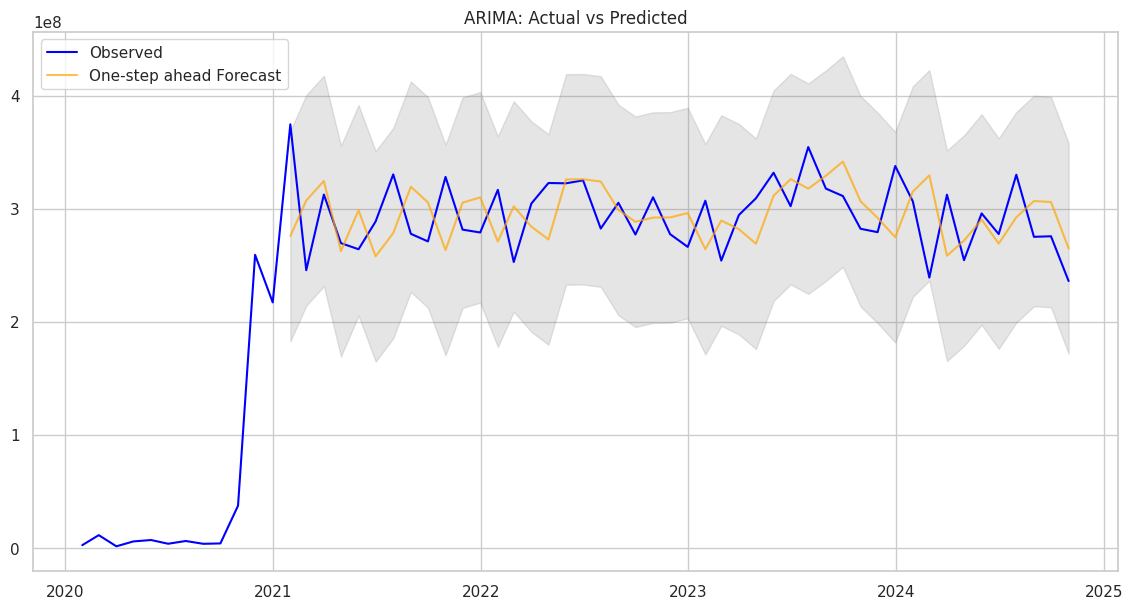

Mean Squared Error (MSE): 1451203973807791.00
Root Mean Squared Error (RMSE): 38094671.20
Mean Absolute Error (MAE): 31543135.53
Mean Absolute Percentage Error (MAPE): 10.77%


In [13]:
# Get predictions for the training period
pred = arima_results.get_prediction(start=pd.to_datetime(monthly_sales.index[12]), dynamic=False)
pred_ci = pred.conf_int()

# Plot predictions against actual values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Observed', color='blue')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='One-step ahead Forecast', color='orange', alpha=0.7)
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('ARIMA: Actual vs Predicted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate error metrics for in-sample predictions
y_true = monthly_sales['Total_Sales'][pred.predicted_mean.index[0]:]
y_pred = pred.predicted_mean

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print error metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


# **10. Forecast Future Sales**
Generate forecasts for the next 12 months and visualize the results.

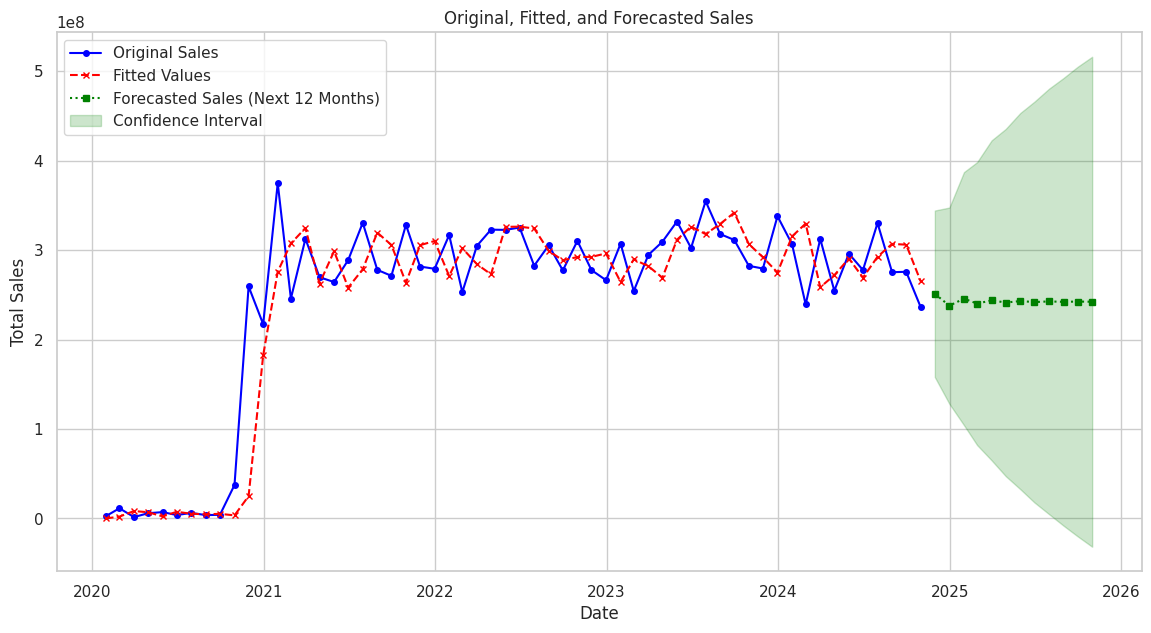

In [15]:
# Forecast for the next 12 months using ARIMA
forecast_steps = 12
forecast_arima = arima_results.get_forecast(steps=forecast_steps)
forecast_ci_arima = forecast_arima.conf_int()

# Create a date range for the forecast period
last_date = monthly_sales.index[-1]
forecast_dates_arima = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                     periods=forecast_steps, freq='M')

# Create a dataframe with the forecast values
forecast_df_arima = pd.DataFrame({
    'Date': forecast_dates_arima,
    'Forecasted_Sales': forecast_arima.predicted_mean.values,
    'Lower_CI': forecast_ci_arima.iloc[:, 0].values,
    'Upper_CI': forecast_ci_arima.iloc[:, 1].values
})
forecast_df_arima.set_index('Date', inplace=True)


# Plot original, fitted, and forecasted sales values
plt.figure(figsize=(14, 7))

# Plot historical sales data
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'],
         label='Original Sales', color='blue', marker='o', markersize=4)

# Plot fitted values from the ARIMA model
plt.plot(monthly_sales.index, arima_results.fittedvalues,
         color='red', linestyle='dashed', label='Fitted Values', marker='x', markersize=4)

# Plot forecasted values for the next 12 months
plt.plot(forecast_df_arima.index, forecast_df_arima['Forecasted_Sales'],
         label='Forecasted Sales (Next 12 Months)', color='green', linestyle='dotted', marker='s', markersize=4)

# Add confidence intervals
plt.fill_between(forecast_df_arima.index,
                 forecast_df_arima['Lower_CI'], forecast_df_arima['Upper_CI'],
                 color='green', alpha=0.2, label="Confidence Interval")

# Labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Original, Fitted, and Forecasted Sales')
plt.legend()
plt.grid(True)
plt.show()

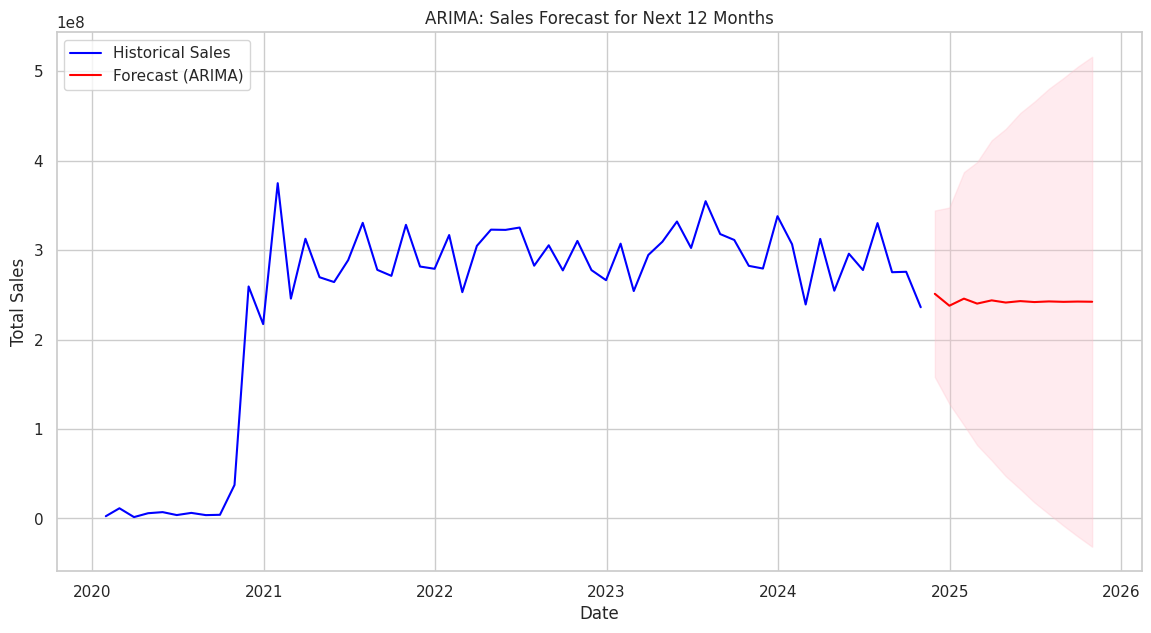

,Forecasted_Sales,Lower_CI,Upper_CI
Date,,,
2024-11-30,2.511134e+08,1.580062e+08,3.442206e+08
2024-12-31,2.378220e+08,1.280872e+08,3.475568e+08
2025-01-31,2.457174e+08,1.042922e+08,3.871426e+08
2025-02-28,2.401830e+08,8.205176e+07,3.983143e+08
2025-03-31,2.437882e+08,6.487207e+07,4.227044e+08
2025-04-30,2.413643e+08,4.726342e+07,4.354651e+08
2025-05-31,2.429717e+08,3.267293e+07,4.532704e+08
2025-06-30,2.418994e+08,1.788796e+07,4.659107e+08
2025-07-31,2.426129e+08,4.851707e+06,4.803740e+08


In [16]:
# Forecast for the next 12 months using ARIMA
forecast_steps = 12
forecast_arima = arima_results.get_forecast(steps=forecast_steps)
forecast_ci_arima = forecast_arima.conf_int()

# Create a date range for the forecast period
last_date = monthly_sales.index[-1]
forecast_dates_arima = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                     periods=forecast_steps, freq='M')

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Historical Sales', color='blue')
plt.plot(forecast_dates_arima, forecast_arima.predicted_mean, label='Forecast (ARIMA)', color='red')
plt.fill_between(forecast_dates_arima,
                 forecast_ci_arima.iloc[:, 0],
                 forecast_ci_arima.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA: Sales Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Create a dataframe with the forecast values
forecast_df_arima = pd.DataFrame({
    'Date': forecast_dates_arima,
    'Forecasted_Sales': forecast_arima.predicted_mean.values,
    'Lower_CI': forecast_ci_arima.iloc[:, 0].values,
    'Upper_CI': forecast_ci_arima.iloc[:, 1].values
})
forecast_df_arima.set_index('Date', inplace=True)

# Display the forecast values in Jupyter Notebook
from IPython.display import display
display(forecast_df_arima)


# **11. Compare With Alternative Models**
Implement and compare alternative time series forecasting models.

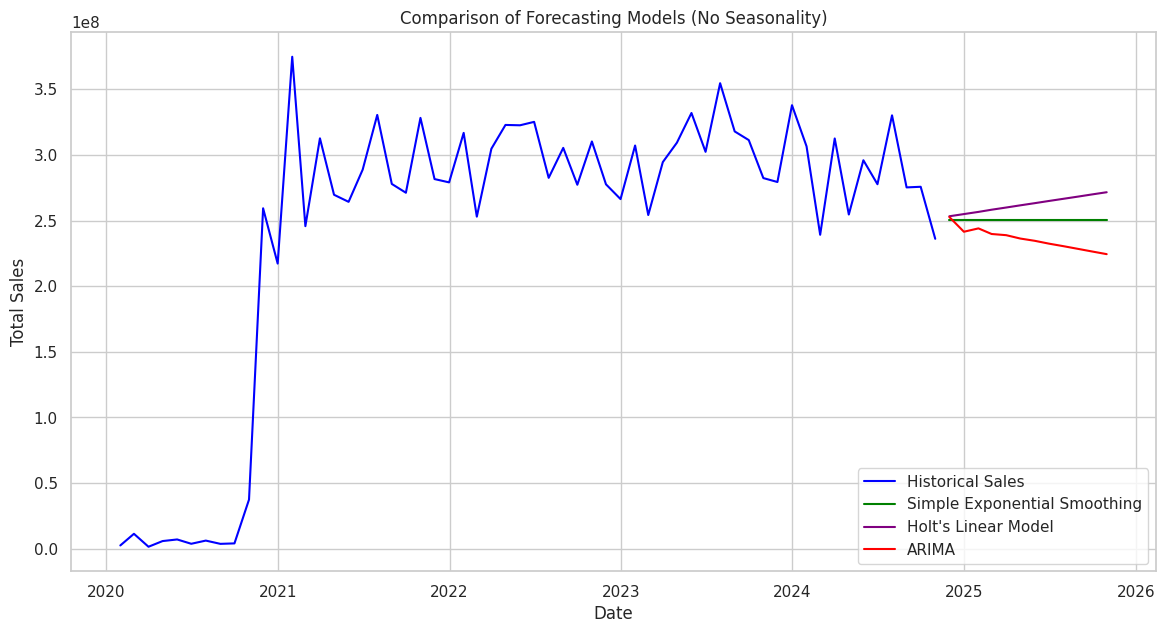

Comparison of Forecasts for the Next 12 Months:
            SES_Forecast  Holt's Linear Forecast  ARIMA_Forecast
Date                                                            
2024-11-30  2.503876e+08            2.532780e+08    2.527188e+08
2024-12-31  2.503876e+08            2.549425e+08    2.414886e+08
2025-01-31  2.503876e+08            2.566070e+08    2.440395e+08
2025-02-28  2.503876e+08            2.582715e+08    2.397691e+08
2025-03-31  2.503876e+08            2.599360e+08    2.388751e+08
2025-04-30  2.503876e+08            2.616005e+08    2.363098e+08
2025-05-31  2.503876e+08            2.632650e+08    2.345718e+08
2025-06-30  2.503876e+08            2.649295e+08    2.324243e+08
2025-07-31  2.503876e+08            2.665940e+08    2.304794e+08
2025-08-31  2.503876e+08            2.682585e+08    2.284343e+08
2025-09-30  2.503876e+08            2.699230e+08    2.264388e+08
2025-10-31  2.503876e+08            2.715875e+08    2.244187e+08


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Define forecast steps
forecast_steps = 12

# 1️⃣ Simple Exponential Smoothing (SES) - Best for short-term forecasting, no trend
ses_model = SimpleExpSmoothing(monthly_sales['Total_Sales']).fit()
ses_forecast = ses_model.forecast(steps=forecast_steps)

# 2️⃣ Holt’s Linear Model - Captures trend without seasonality
holt_model = ExponentialSmoothing(monthly_sales['Total_Sales'], trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(steps=forecast_steps)

# 3️⃣ ARIMA - Best for trend-based forecasting without seasonality
arima_model = ARIMA(monthly_sales['Total_Sales'], order=(1, 2, 1)).fit()
arima_forecast = arima_model.forecast(steps=forecast_steps)

# Create a date range for the forecast period #This is the fix
last_date = monthly_sales.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


# Plot comparison of forecasts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Historical Sales', color='blue')
plt.plot(forecast_dates, ses_forecast, label='Simple Exponential Smoothing', color='green')
plt.plot(forecast_dates, holt_forecast, label="Holt's Linear Model", color='purple')
plt.plot(forecast_dates, arima_forecast, label="ARIMA", color='red')
plt.title('Comparison of Forecasting Models (No Seasonality)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Date': forecast_dates,
    'SES_Forecast': ses_forecast.values,
    "Holt's Linear Forecast": holt_forecast.values,
    'ARIMA_Forecast': arima_forecast.values
})
comparison_df = comparison_df.set_index('Date')

# Display the comparison
print("Comparison of Forecasts for the Next 12 Months:")
print(comparison_df)